In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.metrics import mean_squared_error
from sklearn.metrics import mean_absolute_error

from modules.nelme import nelmead
from modules.nn import NN

In [2]:
sns.set()
sns.set_style(style="whitegrid")
sns.set_color_codes("colorblind")

# Reed-Frost model
In the Reed-Frost model for the spread of an epidemic disease, people
is classified into Susceptible, Infected and Removed. The state of the
system is identified by the couple $(s; i)$, the counts of susceptible andinfected individuals. If the total population is $N$, removed are $N-s-i$.
In this model the duration of the infectious period is the unit of time:
all the individuals that were infected at time i will become removed
at time $i+1$. Meanwhile, however, they are capable to spread the
infection to people in the susceptible compartment. In particular, for
each susceptible, there is a small probability p that she will get infectedby a contact with each of the infected. She will escape the contagion only if it fails to be infected by all the infective, and that happens withprobability $(1-p)^i$.
To simulate the system from the state $(S_n; I_n)$ you can simulate the
next number of infected as a binomial random variable
$$I_{n+1} \sim Bin(S_n, 1-(1-p)^{I_n})$$
Then $S_{n+1}$. Each person that gets infected causes surely
recovers, but his treatment causes a unit of cost to the health system.
The probability of one to one infection p without any intervention is
0.003, but it can be arbitrarily reduced can be reduces if containment
measures like social distancing are taken. However this measures also
have an additional cost in terms of impact to the economy of the country. Say that bringing such probability to a value of $p \in [0.0005, 0.003]$ has a cost of
$$c(p) = (\frac{0.003}{p})^9 - 1$$
The objective of the project is to find the optimal level of containment
measures (and thus the corresponding probability of one-to-one
infection p) that minimize the total average cost (health system plus
containment).

## Simulation

In [3]:
N_DAYS = 60
N_SIM = 1000

N_PEOPLE = 1000
S0 = 999
I0 = 1

HEALTH_COST = 1

In [4]:
def simulate_new_day(S, I, p, N, approx):
    Inew = np.random.binomial(S, 1 - (1-p)**I, N)
    Inew = approx(Inew.mean())

    Snew = S - Inew

    return Inew, Snew

In [5]:
data = []
cost = []

np.random.seed(42)

for p in np.linspace(0.0005, 0.003, 11):
    data.append([0, I0, "infected", p])
    data.append([0, S0, "susceptible", p])
    data.append([0, N_PEOPLE - I0 - S0, "removed", p])

    Iold = I0
    Sold = S0

    c_economy = (0.003 / p)**9 - 1
    c_health = I0 * HEALTH_COST

    for day in range(N_DAYS-1):
        Inew, Snew = simulate_new_day(Sold, Iold, p, N_SIM, lambda x: round(x))

        c_health += Inew * HEALTH_COST

        data.append([day+1, Inew, "infected", p])
        data.append([day+1, Snew, "susceptible", p])
        data.append([day+1, N_PEOPLE - Inew - Snew, "removed", p])

        Iold = Inew
        Sold = Snew

    cost.append([(c_economy + c_health) / N_DAYS, p])

data = pd.DataFrame(data, columns=["Day", "n", "Class", "p"])
cost = pd.DataFrame(cost, columns=["Cost per day", "p"])

In [6]:
data.head(6)

,Day,n,Class,p
0,0,1,infected,0.0005
1,0,999,susceptible,0.0005
2,0,0,removed,0.0005
3,1,0,infected,0.0005
4,1,999,susceptible,0.0005
5,1,1,removed,0.0005


### Visual representations

[]

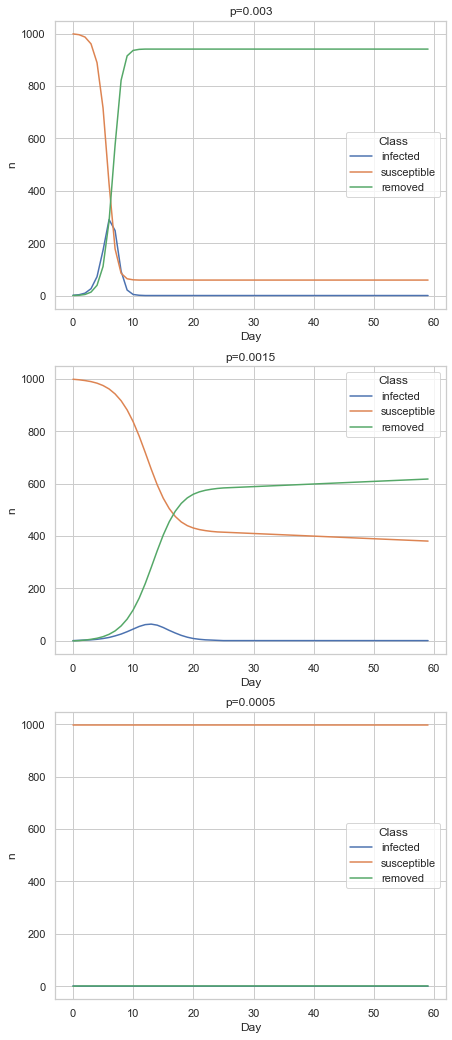

In [7]:
fig, ax = plt.subplots(3, 1, figsize=(7, 18))
ax[0].set_title("p=0.003")
sns.lineplot(data=data[data["p"]==0.003], x="Day", y="n", hue="Class", ax=ax[0])
ax[1].set_title("p=0.0015")
sns.lineplot(data=data[data["p"]==0.0015], x="Day", y="n", hue="Class", ax=ax[1])
ax[2].set_title("p=0.0005")
sns.lineplot(data=data[data["p"]==0.0005], x="Day", y="n", hue="Class", ax=ax[2])

plt.plot()

The last simulation is flat since the probability is $\frac{5}{10000}$ which means that over 1000 people on average the first day no one will be infected.

[]

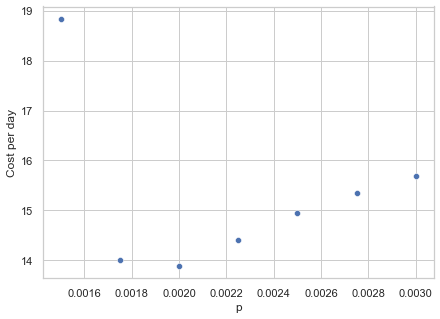

In [8]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.scatterplot(data=cost[cost["p"]>=0.0015], x="p", y="Cost per day", ax=ax)

plt.plot()

# Neural network function fitting

In [9]:
cost_of_interest = cost[cost["p"]>=0.00125].copy(deep=True)

cost_of_interest.index = [i for i in range(len(cost_of_interest))]

In [10]:
params = {
    "hn": 5,
    "bib": .5,
    "bhb": .5,
    "wb": .3,
    "kb": .3,
    "tol": 1e-8,
    "lr": lambda t: 1e-4*np.sqrt(t),
    "me": 1000000,
    "sri": (-2, 2),
    "sro": (0, 1)
}

In [11]:
nn = NN(**params)
np.random.seed(42)
nn.fit(np.array(cost_of_interest["p"]).reshape(-1, 1), np.array(cost_of_interest["Cost per day"]).reshape(-1, 1))

y_hat = nn.predict(np.linspace(0.00125, 0.003, 1001).reshape(-1, 1))

[]

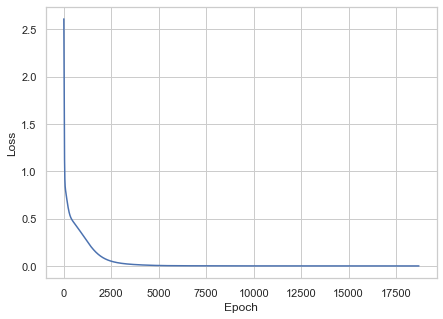

In [12]:
fig, ax = plt.subplots(figsize=(7, 5))
ax.plot(nn.loss)
ax.set_xlabel("Epoch")
ax.set_ylabel("Loss")

plt.plot()

In [13]:
pred = np.hstack((y_hat, np.linspace(0.00125, 0.003, 1001).reshape(-1, 1)))
costs = pd.DataFrame(pred, columns=["Cost per day", "p"])
costs["Class"] = "predicted"

In [14]:
sim = []

for p in np.linspace(0.00125, 0.003, 1001):

    Iold = I0
    Sold = S0

    c_economy = (0.003 / p)**9 - 1
    c_health = Iold * HEALTH_COST

    for day in range(N_DAYS-1):
        Inew, Snew = simulate_new_day(Sold, Iold, p, 1000, lambda x: x)

        c_health += Inew * HEALTH_COST

        Iold = Inew
        Sold = Snew

    sim.append([(c_economy + c_health) / N_DAYS, p])

simulation = pd.DataFrame(sim, columns=["Cost per day", "p"])
simulation["Class"] = "simulated"

costs = costs.append(simulation, ignore_index=True)

[]

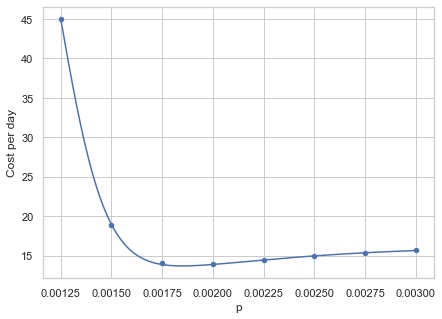

In [15]:
fig, ax = plt.subplots(figsize=(7, 5))
sns.lineplot(data=costs[costs["Class"]=="predicted"], x="p", y="Cost per day", ax=ax)
sns.scatterplot(data=cost_of_interest, x="p", y="Cost per day", ax=ax)
ax.set_xlabel("p")
ax.set_ylabel("Cost per day")

plt.plot()

[]

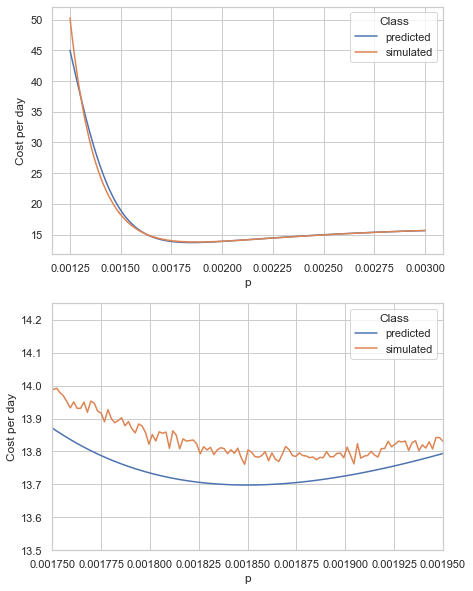

In [16]:
fig, ax = plt.subplots(2, 1, figsize=(7, 10))
sns.lineplot(data=costs, x="p", y="Cost per day", hue="Class", ax=ax[0])
sns.lineplot(data=costs, x="p", y="Cost per day", hue="Class", ax=ax[1])
ax[1].scatter(np.linspace(0.00125, 0.003, 10001)[np.argmin(costs.loc[costs["Class"]=="predicted", "Cost per day"])], np.min(costs.loc[costs["Class"]=="predicted", "Cost per day"]))
ax[1].scatter(np.linspace(0.00125, 0.003, 10001)[np.argmin(costs.loc[costs["Class"]=="simulated", "Cost per day"])], np.min(costs.loc[costs["Class"]=="simulated", "Cost per day"]))
ax[1].set_xlim(0.00175, 0.00195)
ax[1].set_ylim(13.5, 14.25)

plt.plot()

In [17]:
mse = mean_squared_error(costs.loc[costs["Class"]=="simulated", "Cost per day"], costs.loc[costs["Class"]=="predicted", "Cost per day"])

print(f"MSE between simulated and predicted values: {mse}")

MSE between simulated and predicted values: 0.4310731458145926


In [18]:
mae = mean_absolute_error(costs.loc[costs["Class"]=="simulated", "Cost per day"], costs.loc[costs["Class"]=="predicted", "Cost per day"])

print(f"MAE between simulated and predicted values: {mae}")

MAE between simulated and predicted values: 0.2572260158944654


# Minimum

In [19]:
x0 = np.array([[1e-3], [0]])

In [20]:
def f(x):
    if x.shape != (2, 1):
        x = x.reshape((-1, 1))
    return nn.predict(x)[0][0]

In [21]:
opt_res = nelmead(f, x0, tol=1e-8, verbose=False);

In [22]:
print(f"Optimal value of p found via Nelder-Mead method: {opt_res[0][-1][0][0]}")

Optimal value of p found via Nelder-Mead method: 0.0018497135925292629
